## Implement the environment dynamics $p(s',r | s,a)$

In [ ]:
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

#### Create hex board
After a lot of trial and error, I found that shearing a hexagon by 30 degrees and using a coordinate system worked pretty well

In [ ]:
# edges: (x-coord % 2 == 1) OR ((x-coord % 2 == 0) AND (y-coord % 2 == 1)) (and board[coord] != 0)
# vertices: (x-coord % 2 == 0) AND (y-coord % 2 == 0)                      (and board[coord] != 0)
# faces: a little ugly: 
        #  (x-coord == y-coord) AND x-coord % 2 == 0  OR                   (and board[coord] != 0)  
        #  abs(x-coord - y-coord) ==  6 AND x-coord % 2 == 0               (and board[coord] != 0)

In [ ]:
inds = np.array([                                                        [0,8], [0,9], [0,10],
                                                                  [1,7],               [1,10],
                                             [2,4], [2,5], [2,6],        [2,8],        [2,10], [2,11], [2,12],
                                      [3,3],               [3,6],               [3,9],                 [3,12],
                               [4,2],        [4,4],        [4,6], [4,7], [4,8],        [4,10],         [4,12], 
                               [5,2],               [5,5],               [5,8],                [5,11], 
                               [6,2], [6,3], [6,4],        [6,6],        [6,8], [6,9], [6,10], 
                        [7,1],               [7,4],               [7,7],               [7,10],
                 [8,0],        [8,2],        [8,4], [8,5], [8,6],        [8,8],        [8,10], 
                 [9,0],               [9,3],               [9,6],               [9,9], 
                 [10,0],[10,1],[10,2],       [10,4],       [10,6],[10,7],[10,8],
                               [11,2],              [11,5],
                               [12,2],[12,3],[12,4],
                ])
inds = inds + 2
board = np.zeros((13+4,13+4))
board[tuple([*inds.T])] = 1

for x in np.arange(17):
    for y in np.arange(17):
        if board[x,y] != 0:
            if (x % 2 == 1) or ((x % 2 == 0) and (y % 2 == 1)):
                board[x,y] = 0.3
            elif ((x == y) and (x % 2 == 0)) or ((abs(x - y) == 6) and x % 2 == 0):
                board[x,y] = 1
            elif (x % 2 == 0) and (y % 2 == 0):
                board[x,y] = 0.6

In [ ]:
node_board = np.empty((17,17), dtype=np.object)
for x, y in np.transpose((board == 0.6).nonzero()):
    node_board[x,y] = Node((x,y), 0)
for x, y in np.transpose((board == 0.3).nonzero()):
    node_board[x,y] = Node((x,y), 0)

In [ ]:
edge_cache = np.where(board == 0.3, 1, 0)
vert_cache = np.where(board == 0.6, 1, 0)
face_cache = np.where(board == 1.0, 1, 0)

In [ ]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(board, square=True, cmap='Spectral')
ax.xaxis.tick_top() # x axis on top
plt.title('Schematic of Catan Map Representations');

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(vert_cache, square=True)

In [ ]:
connection_down_diag = {
    (1, 0):[[2,1],[3,-1]],
    (0,-1):[[-1,-2],[1,-3]],
    (-1,1):[[-3,2],[-2,3]]
}
connection_up_diag = {
    (0, 1):[[1,2],[-1,3]],
    (-1,0):[[-3,1],[-2,-1]],
    (1,-1):[[2,-3],[3,-2]],
}

In [ ]:
class Node:
    def __init__(self, loc, data): 
        self.loc = loc
        self.membership = 0
        self.data = data

    def __str__(self):
        return f'{self.loc}, {self.data}, {self.membership}'

connection_dict = {
    (1, 0):[[2,1],[3,-1]],
    (0, 1):[[1,2],[-1,3]],
    (-1,0):[[-3,1],[-2,-1]],
    (0,-1):[[-1,-2],[1,-3]],
    (1,-1):[[2,-3],[3,-2]],
    (-1,1):[[-3,2],[-2,3]]
}
    
def check_avaliable_vert(grid, player):

    nodes = []

    for x,y in np.transpose(vert_cache.nonzero()): # for every possible house location
        if node_board[x,y].membership == 0:      # if it isn't already owned
            if assert_surrounding_verts(x,y):      # and if this location isn't neighboring anyone else
                # check for the roads now:
                if node_board[x-2,y+2] != None or [x,y] in [[2,12], [4,14]]: # if it's "down-diagonal"
                    for key, value in connection_down_diag.items(): # then, checking for each nearby road
                        # if you occupy the road
                        if node_board[x+key[0],y+key[1]] != None and node_board[x+key[0],y+key[1]].membership == player:
                            # and you also occupy one of the road's neighbors 
                            if (node_board[x+value[0][0],y+value[0][1]] != None and\
                                node_board[x+value[0][0],y+value[0][1]].membership == player) or\
                               (node_board[x+value[1][0],y+value[1][1]] != None and\
                                node_board[x+value[1][0],y+value[1][1]].membership == player):
                                nodes.append(node_board[x,y]) # add the house location to the possible house locations
                else: # otherwise if it's "up-diagonal"
                    for key, value in connection_up_diag.items(): # then, checking for each nearby road
                        # if you occupy the road
                        if node_board[x+key[0],y+key[1]] != None and node_board[x+key[0],y+key[1]].membership == player:
                            # and you also occupy one of the road's neighbors 
                            if (node_board[x+value[0][0],y+value[0][1]] != None and\
                                node_board[x+value[0][0],y+value[0][1]].membership == player) or\
                               (node_board[x+value[1][0],y+value[1][1]] != None and\
                                node_board[x+value[1][0],y+value[1][1]].membership == player):
                                nodes.append(node_board[x,y]) # add the house location to the possible house locations

    return nodes

# make sure that this house's location isn't neighboring anyone
def assert_surrounding_verts(x,y):   # for a candidate house location
    if node_board[x-2,y+2] != None or [x,y] in [[2,12], [4,14]]: # if it's a "down-diagonal" vertex 
        potential_verts = [[-2,2],[2,0],[0,-2]] # then these are the possible neighbors
        for vert in potential_verts: # for each possible neighbor
            # check that it isn't out of bounds and that it isn't already owned
            if node_board[x+vert[0],y+vert[1]] != None \
            and node_board[x+vert[0],y+vert[1]].membership != 0:
                return False   # otherwise it fails the check
    else:  # otherwise if it's an "up-diagonal" vertex
        potential_verts = [[-2,0],[0,2],[2,-2]] # then these are the possible neighbors
        for vert in potential_verts:   # for each possible neighbor
            # check that it isn't out of bounds and that it isn't already owned
            if node_board[x+vert[0],y+vert[1]] != None and \
               node_board[x+vert[0],y+vert[1]].membership != 0:  
                return False  # otherwise it fails the check
    return True

check_avaliable_vert(0,1)


#def check_avaliable_edge(grid, player):
#    vert

In [ ]:
print(node_board[7,4])

In [ ]:
node_board[8,4].__str__()

In [ ]:
fig,axs = plt.subplots(1,3, figsize=(10,6))
for ind, i in enumerate([0.3,0.6,1]):
    board2 = np.zeros((17,17))
    board2[(board == i).nonzero()] = 1
    sns.heatmap(board2,square=True,cbar=False, ax=axs[ind])
#     axs[ind].set_yticklabels('')
#     axs[ind].set_xticklabels('')

In [ ]:
board2 = np.copy(board)

In [ ]:
t1 = time.time()
[np.argwhere(board2 == 0.3) for i in range(1000000)]
t2 = time.time()
t2-t1

In [ ]:
board2[(board2 == 0.3).nonzero()]

In [ ]:
t1 = time.time()
[np.transpose((board2 == 0.3).nonzero()) for i in range(1000000)]
t2 = time.time()
t2-t1

In [ ]:
ax = sns.heatmap(board, square=True, cmap='Spectral')
ax.xaxis.tick_top() # x axis on top
plt.title('Schematic of Catan Map Representations');

Undoing the shear transformation, we see that this is what we expect from the board:
<!-- Generator: Adobe Illustrator 24.2.3, SVG Export Plug-In  -->
<svg version="1.1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" x="0px" y="0px" width="264px"
	 height="246px" viewBox="0 0 264 246" style="overflow:visible;enable-background:new 0 0 264 246;" xml:space="preserve">
<defs>
</defs>
<image style="overflow:visible;" width="264" height="246" xlink:href="data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/7AARRHVja3kAAQAEAAAAHgAA/+4AIUFkb2JlAGTAAAAAAQMA
EAMCAwYAAAoEAAAR3wAALur/2wCEABALCwsMCxAMDBAXDw0PFxsUEBAUGx8XFxcXFx8eFxoaGhoX
Hh4jJSclIx4vLzMzLy9AQEBAQEBAQEBAQEBAQEABEQ8PERMRFRISFRQRFBEUGhQWFhQaJhoaHBoa
JjAjHh4eHiMwKy4nJycuKzU1MDA1NUBAP0BAQEBAQEBAQEBAQP/CABEIAPYBCAMBIgACEQEDEQH/
xADSAAACAwEBAQEAAAAAAAAAAAAABQQGBwMCAQgBAAIDAQEAAAAAAAAAAAAAAAAEAgMFAQYQAAIC
AgEEAgIDAQEBAQAAAAIDAQQABQYQERMUEhUwFiBAByEiMVARAAIBAgQCBQcICQQBBQEAAAECESED
ADESBBBBUWEiMhMgcaHR0jMFgZFCkiOTFDQwQLHB4VKio9PwYnLic1DxwuMVwxIAAQMDAQUFBwQC
AwAAAAAAAQARAiExEkFRcZEyAxAgYYEiMKGxwdHhE0BCYqJykvBSI//aAAwDAQACEQMRAAAAz8AA
AAAAAAAAAAAAAAAAAAAAAAAAAHGzYDpgXQAAAMa+hP0Xz6AfPoB8+gB8+gHz6BeH2ZaXn5EWM0Wq
2SpKxl2iv0nV85ebX/Po2/yUPF/EeVoqD67JWRLVVYcJUUqnvEjOdGAADGwJ+iAAAAAAAALDXu1f
LotbesxWlefkfUZkNEZw0VcTstXPRsp1Wzz6J9S/Zq+OHdEPuwtZdFOnNR71tWJ2QNcADGwJ+iAA
AAubmgaTn5Kni6WrWepEdl2mt1XTM3da5yF87Sj4iMoJ2boeV3jNHCl7ESWXMI0st+ZXr6C9HLL1
RGuhQyrGnZ7yMMDjGuGbgSAJ+iAAHyGTXy0cG3nNVq3iFy0mGDWtfeGjKe8rMVz36wXaznTrGJxu
HWE6yaKtzm1161h9XE7NA71C1ZqdBr+o5i4hePdO06xDJBymmwAHW3ZQ3ltAHWHzipaWnnVxPes0
5Pt4iT9I4R2UDvWV6zC+5vJKK3Q1V67Mmyu3rUd5q9tSaFG7aLnWPP8ADKMC+UNjn6F+pF/5IY2I
3Wq8dCvT8t1+l1QqQF9gxXe+3OTz6luFlrXqENIRTu+UpnvuVC13O/qMThaZPFtkVV7z8QuzciYn
boMik2/PUo8W3VF9vt94DNbdlXLzncXQXlG7H7X3ilpSyX/FtdVRykvpYZ2MltxNnpG8tToB15xd
cy0NJHmhu0JemrSm8vtyZfc6lZVCU8O+g364z+TKcK60qag/oFctnnPy6Z0e+pPJu9k89Spiohu6
px7F0kbpfFrwd2KwJRk5P+gMhe5XZMYJvPcSRLdcz5DLOoieEqViNp+1U7fpPqmWpNOicLVVdB6V
9iDK86Wvu6FkP1Io1dFo51YuYu7jMbuuv4pWhU6y1cA6x4Tu4PEvhCIZX6AUtjpgPm6UsOtrp+iV
scGVkpazMis8pDzXPwx4tLQ7tSWaDd0qV95I52e+7f7sdp7i08xOvKFsdnQ6fJnvRRWs1/hXR0eJ
6c5WVlPyx1zT1D59JzTE8jlbcBxKPh+8UkM178ANoM+u+Y3QedmrOlqzfsEZVmdOd1QuiS+VGqXu
fKnFrF/Z5feV1o1N0KlXXxpUE0CV2X2xbsCylbTpfUT4O3gFlwAGyAQ86efQGJq9eyEPuoZc/os0
Gl6PxVazb7efdrlFsNr4RTUoVHJh/wBfJ/rRTWuFPlV/RV85pl5eYGhR73aPKvMoXRc4dVGPfgH2
QAAANkAh50AAyXWloYievIahY8QbrtaTxz0hoadJyy81KwahoNIYa5zFpoQmQy4LzQaMqq6NN7W5
4WT0NllQGp5pHL5AFzIAAAGyAQ86AAABndD3jEwhz4HotdHj3PdHaT7DmgrG0/LzcrNA4tuUWXeZ
BTE5LK9VPnz9edBoA6AAAAAAAAbIBDzoAAABTbkB+fx0lCWxR9+vNRUdYtmgYmzWS1Zbn3OiOjss
l9hqOac4LE5oqGHGoqAaioBqKgGoqAaioDeQI5IAAAAAFTysAAAAAAAAAAAAAAAAAAAAAAAAA//a
AAgBAgABBQD+vZX8TmMGcqs7xkxlc+0uD4l+BwSYAwgOICYNQEP/AKWYHBjn/wAmShq/5WBIDkiy
DLKxCUImMeHbLSu8TMxEGWJbImJTGFPef4OEiAWlBQtUwaFkMEazA4ISIphhNAlQpgeJePXKzrN+
YFPaYnvGRPSwTAKvC2YgQ7OXEZbVGQwxiLDcUUGaAWBGoZGwryAsvgUxBCo/+5HRofMBMlmB94Iz
mGMcJLBLA9dWPXKzrt8geQ8tE0DreNg/GBiwExPmjxZE9Lao7i5gDFp2LkWsQpQSaR+L1QwAMl57
TslxFi0qHoQxMeOfn0/+wyw2JWhJh6iscEqNDfIHmPLLmrNELdnqKyynxxTd36TGdo79GmYDHxey
sgAk0RA2FeQFsJU+6zDfLIVWWJQkJhgQUSMrNZwY52/70n/uNElmlkMDznlh7VmkAdnpLywnxZUb
3gGkMWnMiAOHsWqF/wArCvmKmkrPdLGP8kKrCBeCJhi4IfiSz90sm3JCqsBjH8yqwRejjkyrKjvl
AOkYsv8AjHzF7Jpd8il2xKZX+COjAgwiCWfujk2gIV1SKI79vxROd8en5zNQ5yKjIxCzXnfO+d87
53zv/S//2gAIAQMAAQUA/r3U/BldnyGyvsVB3eMvp7iczEAcFH4DHvET/wBgQwgEogfgQzExMRMW
E+Jncktie/8AK4BrYhsmNiDEqLvmN5ZRlF8zl9U9qzpgrMFIzMzj1/MazO8fwOJmO/eRUqMJQFAg
IF/5IYSqMP5RIKTMfAcNICVhfwIw+BxPeMqP8q8uE5Z02w2LnlXlKxJ5eExitYPu82/GrYkmWAOF
otshllZGsmGUFHeA/wCdK7vEyJiYYsWCCxWUwJiNdQyclgIRMeMMOusSWXyH1k4fyDASk8u1oDO3
Wg/5Dl2GBla0yZe10DWsSxj4MFous8jwIlqtMEyYyRi275BAdjCDFi5WfRbCWYHBgwimAponPCGH
UWJAXyGaKJkpIMislkigIh1Rfev2GMvJ+QdU2mKFFnzMb81LTeImPEpBVw4InM7e8wpEI7TecJRI
mB2GrNTIYGenPsdVJWQgXyGdemZIiXkVFNIa4jDqYfKt2EXVFtIV+ADUDzSgUx/FTZXKrswRPLtN
+SwV9sm+Yl/wwKyxZhZ+QtumJJgWB/OvWh0DXmBdS/8AVbuIPpw01gSFuQLzVUleNpwzK9aUz/ND
ZUyJiYIflE2vgY2BIWXhGVD5B/HWuCsPsE5aappJd8Mc0GZVs+GfsE59gnPsE59gnPsE59gn+l//
2gAIAQEAAQUA/ucV3P0u6WxbV/8A4H+dcgK5U/PxLazbqREDFtXwOIiMptztHfl+qixV62Ew5cxM
TStFVsD2KNnT9Sx01mxs6u9QvV9jS/Nrr7tdbS1blMXDAmJGRKRlZwYGAGG9131uy630wJZorctD
Y0ot1uv+b71gWfy8emhZT9dr83q7lVH221ydlsSn7HYZoN1YXa8rc3dI9jU6mAsBiyWaHGh1Zy7K
N9RlLui2MUzjm7VvNX+SnZOparvXZQxYNXfpMo2uun2EX6mch181rXW+j5jnHbwqdbpjarWEMrP6
cH5AOm2n8+M/WbGj9Tqss6nXrP67X5U1+rOPqdVnKKDatX7HYYFg3N8S8sJGQzRbONbe8SssUatl
c62gMhQ14lGq1JROo1MxyPTTpdoJEBam7Gxpcp1cePrwfkBbnV/y0+yZrLwGBg5cNCYmJA5AgKDF
yluVtteetv4hvkDHq8Z5xLazbqZcV0pt6cw0cbbV5x3Z+hebXW5W1oHrr3Tjm7bo9p/HR09Vdr/Q
anNo/Zaiv+073C5DuDL7/bZoeQ2zf7T85FVbsKmAZBPsuys9ZWB0WnMU6mnVN3I+RIbPJ94Uff7b
I5BtxmltSu1vafnL9Wypss4psguUOUak79D8GuuFStrYDV2ELsotVm1LHQSIC1t4L9TN5r5pW+vG
9hDq+cm18zHXjuwitZzca4Nnr3KYh2n2J6zYJNb08o05azYdKr/Mvrx7UarbL/StVmzRa0FH9o2G
WrxbN/qLx1aADOPbBdO76Ss2Gkq3688WoRMcX1/cOGakxRxKlVbb3+1qWWclutWuulgeovHKlRZo
bKNpS9JWc94/KSzg24E177TxttcYGs8rOlLOuuvu11tLVuVYrpsp2FNlC7EzEpZ5FzETDl+NmcW2
h36GXFQM5TbMTnMtWBJysyRPHLhgZodoesv5aq17lfa69us2Fay+o/WXVbLX880oVX9KDvmvrxTb
OXnutzlNYrlbFtJU+2zEmuzY/V9flDTp1tguZ7cCPmezMf2jYZHKdhE67cndqHaIw2dP0rmRbZEe
2zNRr6Wzz9X1+Xtre0VX912uck2VjcRnA9v6uwu0U3ql6m+hcxTJUwDEx6LYamUrartbNtQKjb68
evjZqZyagQt66C+NO3m/oFcqdadk6lpLlPVcrBbquS1DcsplLc4vul7nV/6Do2Wa3TXv7T141e8N
30c2ugDYV/1PP1PI4PBRQ4kyjadydiW2OSrsoCrBh6eNXKzzjdn7On6OX+IhFj9TxHDobP6LjKdj
jus/bM2d9d9+WkeZecV3paTZsUtq+Q6hml22CUiSGw5XXj21nZ0Mtq+B5Tb05lqoGcqt+JZYV5Az
T7JmsvAYGDlw0JiYkDkCAoMXKW5W21562/1vI8bM4BvZ2Gv51x77bW9KT/EzErhrf1fYZptbtNTb
LmesAmcy1LA/aNfg8qojNPcVLiLDallN6mylZiZiRth8fbXlTWlsT/V9hlG/Z0ev/ddVj+V6sz/a
Nfms5RQc73VZyaorYVOrVC1ZCQFp9rZ1Gwzm2gLT7bpTf5V5o9hF2pnJNfKbHXjuwitZzkWvmzW6
664VK2tgNXYQuyi1WbUsdBIgLW3gv1M3mvmlb67BHfrybRjvdSxbFMyu7wtXxrdNDV6XfULZ7zVg
dzbaa3V9dkz6zsMCCc0ls9nU9V+bDjOwTZ+g22Bxzcsn9W3ua4buoo/f6nN4/XX59Z2Ehoxmh2EU
7fqvzaad1+oYGB9CGCFyiSzp/ovHxp2+nAt9NqtnL9SNd+VG/wDcsq+YZoNsWrvY9XlDFMlZxMFF
usq3W2FNlC7EzEpZ5AmImHL8Z5xnbFsaOcv1I139byPIvpfo19jSv0bGuu5RuPoXKe0p3atv07da
zXZWfEzEjZVI+ynE66zcn6DbZqNnOr137Tosscg0pM+/1Oa3e615+0jOW1E26mIb4z9lONJTo+g2
2amhudbfLk+kAre/45brGMCf8v8AR9Ey1W6cM266zs5LQJquupu+jdEhMblYLdVyWob0Ww1MpW1X
a2bagVG3149fGzUzk1Ahb+Bi1tXyPSN0e0wDNZ6TYxt9eSDMb+lv1bP12wwdZsiz6na5p7Lq1P7H
X5yFVWwfiZkrOIzjl/17Pibm51Tr9T67YZ9dsMjVbSY11Xb0rc7CjE2LWrsocqUt/BzbQDuNT04f
vJ1O0yyryLxLJUcTExdppvVbdZtSzEzEqOGBMRMNCVnnHtrOzoZbV8Dym3pzLVQM/j53ol6jbdOE
bktlqstKhbMptkozmWrAk5WZInllcEGaHaHrL+MXDAmJGRKRlZwYWK6bKdhTZQu/i5DqF7rUsWxT
MQ2UtEoIeld7Kz6tlVuuQiY7KidC310ewi7UzkmvlNj+j/pHHyBvTXvjt143sIS7N7r5u1OurvTQ
tiQmNysFurYQys/+hfo19jS2+tbqtlgGSzUyGr6CRAWlvJ2lDxKyzqdes/rtflTX6s4+p1Wcqq2q
J/Y7DGMY0/6P+iaAblHpQd8D68a2s66/jlw0JiYkDkCAoMbtNN6rbrNqWf6fK9EzSbbp7tnPds57
tnPds4nmHI0q/duT4XLuQmX7ZyDA5lyRcfu3J8u7zabBvu2c92znu2c92znu2c92znu2c92znu2c
92znu2fw/wCiq1rNL/Y//9oACAECAgY/AP07i0vj24HSo3duB1sqWlUexIBY3G9Ayc4moKBAiQa2
RiwD6hbJQKEhr2/y+ffcE4yqKrmPFXPFGMgCRW2iwIHgsh5r8g0pJUJC5jxXqNJU7H7pESYyuGLI
ZkzANYyr8UCIQINbBECMYk6gMn/dAoTib1RBlKtLowM5ltpuEJYQ8aC65If6hEVa8dyY80aeXY/c
cSOMkROIM7vtWGIpZCQsvyAeEvkmjIgLnKA6ozegJTYgCSOIYq3qjUISHnuVNahYn/h7hjw3oHWJ
qEJxN6hEZGqlCUidN4QkICt965AiBY1igf3CklzFZCUsZ+4oiUQZi/i+qYBghOPms9bN49z8gF6S
TQkw3Oub3BN1hkSGBt8FjjSXibo4hiE2oqEcDiSub3BATOcXciyE4BnF3OvYQdVh3JQnjsNEJB6+
KseKYWvEoS1FDv7HDYy8NVLMeu9KUVjxQlB8bFHpy3x+Y7Xatu3KIBa7r/09JZgY0fe7rHKTS2tf
giYu4X8o1CJjroVaHA/VYzEcX0v5KM4ynxFRwTgmqlCW5bJRKEhr3WTecShLXXerBUEMZVFDwupG
Txk7kRsrz4j6IGLmJ27UembisUwbzWcRHZKh4oDqekswMacXdERJL7e84vGoRIq+hXKEIyiwe4uE
JxmT8wnErqUJbl/KBXKEQYhjQoTjOQ+R9gSJYvoy5/6/dCuQOtlgbxtuTM6zEH0NfsgG/GWvd/gu
f+v3XP8A1+6PqyB0b2RidfintKBXKUQYljRCcZgajwKD319qJRYHV1ePvV4+/wCiIJBidm39R//a
AAgBAwIGPwD9PkOWddx1TG8fgsxaXxR6UrxrHds7B1Y3jSW5Ot3sWVatoU4A4IggKgAIQIRBsUYf
tNY7lXl+SfvOJSxnUV4hMSXjdZCUml46o9OVZRqH2IdSJIFpAHgUelIubxf3hDqxJpSXyKwJLStv
WUSfTeuiqSd6cXjULA3jbd3aFihmMwDaVfinjCA3RCIMY8E4jEGPgqgEHQpxCETtEQCjEknfqED+
Pp/6hco4JsI+FE45ZLKO9OOyvNCkvkex4zkITt4HVGM6zjV9oQn05GMbEDQowmXkKg+CHUgSBaXy
KwlI1ssoSIxvuWPVOWVAToUT0iYyjWmoQ/JIyiaF9PFHAtKNR9E0i6ZN2CWlpbk41WMg6EhFiExG
UZJ4wESLEIxkXFihIQirBco8F4i65IoYlo2COUImTufNCcA0bSA08e5+KV48v+P27B1IFhaVOBWE
pXtQLKEma9BZY9Y5ZUibV8kZdE4mNTq480B1JPGVLAN4o4FpCsUMpUsaBHGTHQsEBM5RB9UWAQlH
UOPNGMqiQZGBvHtE43iUJRNJBShIAg0KEhlxVlTIaiq+KJY8UAC4Zq3UjIESNaFkAHp4rJjW6wFt
H7PyRHqhf/H7dwxjiQ7+pY9QCJI9OO3zdGXT9TVIls9yEeoIiMqOHvoiYB5CodBxFjdHERfR0BOM
MXqwL/FCUDcODpVGMow9JY3+qBFRIOEYkRBiUJjX469mDf8Anzv/AB2dwSBkCPGxT8US8x5j6IR5
g1zfzUpEyiSXIiQ3wQDyLbVk8vUvxuS1nWUjIFm9KaBMg/7tODIGbxLM8acXdERMiJf9u8Wq6YxD
SRaIJQEoAB6tdZRL0psWMoChY1Ti0g4RiYjKJQkBdGJhH7ITBI2jYfYH14mOmL023QBnk2rLISYS
8NV+Myyxtu2LMSwLVo7+KxJ/IHpo3xQL/jLMaO/wRH5Mgf4/dD1Ykasj68oy0Zq7b+wE9LS3IEVB
DhEIgxIlEshIChRhKEuKE4m/uPtMJiRblZcvU4D6oTgJA2k4uiJORoyBAkJDbsREnMZbNq5epwH1
XL1OA+q5epwH1XL1OA+q5epwH1XL1OA+v6L/2gAIAQEBBj8A/XLO6cxt3+x3P/iciW7rHskBqVMR
zwt20we24DI6kMrKwkEEZg/+gt8H3Bm9s01WHJYl7OqCDMgeGSAK5EADs/qB2d5h421ACZDVaiF5
105GnRzxAECpp0mpxrGTZ+fBIEE1PXyx4R5VX9+C0dowCecDL9uP/wBC0pN/bgC5EmbUmezB7pM+
aZ5eQUOeanrwQRBGYwt0d3JxEypNYwGUypEgioIONKAi041W8z5xPVxs7/aEC/YMrqGpSCCrKR0F
SR+zFnfbY6rO4QOtQSJzVtJI1KaETQ/p7e6sk9kjWoMa0ntIaHP+OEvWjqt3FDo1RKsJBrgqeeR6
D04IOYocBlMEZHAcc8MjqGRgVZWEgg0IIOLlhRFlvtLP/jbIZk9kyteifIF1RAajf8v48G21wktb
GpJ/kyj5P9ZYZQoN1RNo856OWeXkP8E3DlrV0G5swSSEdZe4i9kwGWWzinS36Y7W9YttftywZrYJ
ZCebGagn5ox+Vs/dr6sW7+wvXNvt7Q03LVpzbQamowRYFS1fkx+d3H3r+1iTu7xPSbj+vH5q9943
rx4G5v3HS/CoWZm03JhedAZ/Zjvt85xpXtX7R1WpP1lk9I9MeQUbJhBwUbMYS9bMOhBHqMcjhL9q
dDiRIg0oR8+PxSAC1dMNlS55usCfPPFbtpilxCGR1JVlZTIIIyIxa3qUuj7PcpBULeUAuFkns1kV
yzrP6W3uEqbZkjpGTDI5jCX7RlLgDDKR1GJqOeGtXBKOCrDKQRByw+3uHVpqrwQGU5ET/qfIDN76
3CXRSSY70Dk3r4Hcp7ncEk59l82BP+7MfL0eR4q5oIYdI/hwOzudy8ZtmgAeMj/ygDz+fFzbvQXB
APQc1PLI4exdEPbJU516xMUPLibe4MbPe6bV1pVRbcH7O6xb6K6jNRQzWAP0Gi7s9v8AiNtpS4fC
UlljsuSy5mDNeU88fktv90ns4kbWzpao+zT5ssflbP3a+rBRtnYLCoPhJUfVx+S2/wB0ns4TefD7
jbe1ZhLti0fDthWJhwFK11NB/hj81e+8b14B3LG8SAoa4S5HQBM9OO4vzDGpAAVrAAEjgr3AG292
EvBpgKT3wBNV83SOeO4vzDHh3bSMMxqVWgjnUYIO1syKH7NfVgMdpZYDMG2vqwCNlt4NR9kns4IO
y25BzHhJ7OLmzDF7JAuWHaNTW26dPMEFeUxMYDoSrKZVhQgjIg4XcQFuAlLqiYDjonpBBwPiNvvL
pS8KAEGiv0zMD5ujyDb3BnebLTautLMbiEfZ3WLfSbSZqaiaSB5ablaoexeWAS1skFgJitJFfRhX
RgyMAyspkEGoIIwVOeY8+INCMxgOuYwGGRrh7N0ardxSjrUSrCCKYu7UzoU6rTH6VtqqZgT0GOc8
JPeFDwgd01HA7O8w8bagBMhqtRC866cjTo58PFHOjfu4eEeVV/fwa5bUtvNoGubcCe0KG4mkA6iw
WnXFYngqXCBttwQl0mKZ6GkkRBNeqcPauDVbuKVcVEqwgimLu2adAM2mP0kPdMwJ6DHOeNrepW0f
s9ykBi1liC4WSO1SRXPOk+UUvWgd1bJ1dtwWUmjQCBzj/wB8e4/rf2sWR8MuG1skBVkCq+hixbUW
uBm7Rb/U4/Nf27fsYLNuJJzOi37OPf8A9Cezhttu7wIuR4RIVe3/AC0X6X7uvHe9A9WA6gvf25LI
oFSrRrURHRPyQM+EqYOWO96Bi0N6PE2+r7RarQ01ditJnAdLIZWEqwdyCDzHax4+zTwNyoYWrss+
gspWdLsQc8NZvbgpcQwym3b9jBB3VDQ/Z2/Yx7/+hPZwCNxUVHYT2cJftuO0O0og6W5qaDLHe9A9
WH3qKfw+7JcvyW80l1Jk597lnAy4LtXYfidqNOnm1oURgIGXd/bngXLCF9ztjqRVqWU0dQJHn6aQ
M/0NvcCdIMXFHND3hmPOOvC3bZlHAZTlIIkZ4exdEpcBU5SOsTNRyw+3vRrtmDBkGRII844h0JVl
MqwoQRzGFvrRx2boiAHAExnStOBZABYvktaiKZalgREE06vI/B3CTdsglJmtuen/AGkx5o4Df2wO
yAt/Ic4RuvOD8nkHbXCfC3BAXMxcyHmnI/Jwu7QwHYarTH6NxaqZho6DHKcPYujTctMUdZBhlMES
KZ4tboSUU6bqj6VtqMIkT0iecYt37R1Wrqh0aCJVhIMGuWC6KBtdyWexEUNNaaQBGkmnVHXxk99a
N5+n5fIuW7z3re6tVZVdNLKT3lBQtTI/J0xj3u4+sn+PFttgRf2qtpcXlLOhYkzqt6BpJ6efTNPd
2fqt7eEbcoqOBpDW5EiZAOotjNvR6sakJMZg8Bbvkjb7iEdgQNDT2XJbkJM/Pyxm3zj1YNi4ziCG
VgQCGHydBxBuXgRmJX2MVuXo59pfYwGF7cQa95P8eBf21+8t5J0FyjLJEdpdCyPlHnGLm2vWrIuW
mKt2XgxzEsKHMYa1ctWSjgqwhxIIg5PgMC3WJFPRjNvR6sRmDUHgLjFhuLUJfWVq0d8ADJvWOWM2
+cerA+MbeWtvpt7lYJKtELcnIKQAvKsZzwPwe9R01XNuxKgFSZa3FCSCS3Ok5Rh9qCEugi5ZdphX
XpjpBI55zGGt3FKOhKsrCCpFCCDwBnsmjDlH8PIt7qyT2SNagxrSe0hoc/44S9aOq3cUOjVEqwkG
uHsX0Fy1cEMp54vbS4Za00BqdpTVWoTEqQcSKEYDc8j58Qag4K8sx5uBt3mL7nbEK7NUspqjEwOg
jppJz4C4ogNQ+fh4ZNDVeC/E7SgXLZC7gimpTCoxr9E0ymvQOGknstT5eBEdoVXglwsRtrhC7heR
U01EQe7M0ry58Lm13VsXbF0aXRsiP3Ecjyxf2F0y1htIag1Ke0jQC0alIMTTCbnbObV60dSOuYPq
6RixvrQhbyyVqdLDsuskCdLAiYxb+J7dAlrcEpfC0HjVYNnm4mYHKTU8fDJ7SZf8f4eQ3w9mUpW5
aDSTJjUqnVlzgDpOMl+Y+vC7tVHi7fvFRVrZznM9k16q8CV58jjJfT68WrW5It2mcBnWJANM2MDH
vL31l9jA3W1uXGuqrAI7AI8jJ9KTE1wUexYVlMMpRwQRyP2mCps7eDTuv/kx7uz9VvbxIt2QRkYb
28W9wAmoiLijk47w7x846sMjojIwKsrCQQaEEE4uWACEEFCxkspGc6V/1TgBAMczPrxkvp9eLvju
6X1IOlCoBQ0kAhjnn8mPeXvrL7GNtt9qq3rChl8W/qdpBlVOkoBAy6vNj3W3+q/+TFq/etWku7cF
dVpSGZGrDElidJqOiTwb4deaLG893Jot5e7mwA1js5STpGL2z3Am1fUo2RInJl1AiVNR14vbPcCL
thijUIBjJl1AGGFR1cFuDNTl1c8BlMg5EcVu2zDoQynOCDIzwl+2R2h2lBnS3NTllwZApFhyWsty
0/y5nu5enn5A27sPHsDTp5m2O62Qyy/bnwG+tqSjgLeI+iworGvMU+Tr8gpdYLYvjS7GgVh3WNPk
+WeAe0pa/YOpFFSynvKK/L8keRb3CVNsyR0jJhkcxhb1lg9txKsMXNu9BcEA9BzU5jI4azeUpcQw
yngRHYNVPV/Dhbus4bd2gE3aU1BxQOQAtHjUIEcuRxb+K7ZC93bApuAsk+DVg+eSGZgc5NF4+C2R
kqevo8hdncMWdywUGp03MlgD+YwD8nRjv+j+OBbN3RcQ6rb6QT1jPI+fox+b/t/98fm/7f8A3wCN
9Q1H2P8A9mE3Fve6tNGTwiAynMGLn+jh7N3Z6bltijr4oMMpgiiYexd2kpcBU/aCR1ibZqOWAwfP
q/jjv+j+ONJrzB4Fbjxf28I9CSykdlyTzMGfN147/o/jhrlvcaLdwllTwxCzmBDCnRTH5v8At/8A
fBH43SRX3U//ANMfnv7X/wBmHuB/xtpHErHhG2r0JqzyNUUA5k4/Kf3P+mBfWz4LxpftBg0ZHurX
+HCB31qvn6Pl4LccztL8WtyCWhVJ94AsyyeY0kc8NbuKHtuCrowBVlIggg5g4v7FpNtTqsO09u01
UM6Vk8mgRqB4BhQgyD1jAfnkR18/ID3WB3No6L0QJ/lfSD9IemY4axk2fn4eEeVV/fwX4pZU9ohN
zmeQCPlTLSa9HDQcmy8/CR3lqOCblaoexeWAS1skFgJitJFfRhXRgyMAyspkEGoIIwVOeY8+INCM
xgOuYwGGRrh7N0ardxSjrUSrCCKYu7UzoU6rTH6VtqqZgT0GOc+R4i918/8AlwPw7cMPxOxCrboF
LbeNKUmpSIJj+XmcfitrZ1/EdpBTQJuXLX07eYmJ1DM0he9x0sYttnOQPTwW2XW3qMa3JCjzkA49
5Z+s3sY8cOlywRF6yjEFxBiNSAagcqjokAnBR7G4VlMMpRAQRyP2mCps365HSlD0+8x7u99VfbwG
VLwIyOlfbwt+zqKtmKSrc1Ncxh7F+2blq4IZSBX04fb3AeyToYiNaT2WzOfnxIoRgagdXOIxk3o9
eH/C3LaFam25IaOkQrUx7yz9ZvYwLfxJX3FtGi1csw+hDQI+vQQJyNeilMe63H1U/wAmNSWrwnMF
Uz6feY93e+qvt4G2IuIX92XCgav5RDHPGTfMPXjxrFsnd2KqQBqdPpJ3uuRn0DPyCjc8j0HpwVYQ
wzGLW+27EFCBcQGBctyNdtqGjeameY4NctKF2O9LXNsFI7JoblvSoXSFZuzTuxWZ4gHvpRv3GeAV
yTfsALdma56WkzMgV6+H4y2ALV4gPEUuR0f7gJ88+QdtcJ8LcEBczFzIeacj8nAbm2B4u3BLZCbe
Z88Zj5fIt7gTpBi4o5oe8Mx5x14W7bMo4DKcpBEjPD2LolLgKnKR1iZqOWH296NdswYMgyJBHnHE
OhKsplWFCCOYwt9aOOzdEQA4AmM6VpwLIALF8lrURTLUsCIgmnV5AvLyo/7jxubIMEvgi7t7jTpW
4vTp5FSV5xMwYw1q6pS4hKujAqyspggg5EcA+YyYdWFuW9uHtuAyOt20VZSJBBD1Bwt/8IWQgrcU
XLUlT0S/I1wyPeKupKsrW7gIIoQQVxc277iBcEA6LlDmp7oyODoh1mjA0PWJg47vpGNLCDw1gTet
Ql4SszHfilG83T0Y7vpHrww29rXYbtWyGUaQT3Tqblj3H9ae1ghNvJHLxLY/+ePyv9y37eGX4pZa
zYtt2LwK3ANZ7rC1qIrzPTHRj3/9D+zi3e2t4NuEGgoVddazIgsAtK47vpGCxWgzy4aLnub8I5JA
Cmey5LchNa47vpHrw1iArghrbE0DDpg8xTDI6lXUlWVhBBFCCDxKmoIgjqOChrGR6RxX4xtxFneP
pvoAoCXtMgiIJ8QAk0zBJPa4n4RuD9ttVnbsSxZ7U1WsjsSAK5RTsngPiNmlvctpurAAW5EyI/ng
k9c1rw8M5Gq+rhrHeX9nAO35e7CXwSYCz34War5ukc+EDvCq+rgHHyjpGARkajFzbXhNu6pVspE8
xINRmMXtpcMtaaA1O0pqrUJiVIOJFCMBueRHXiDUHBXlmD1cNF38xttKXDJJZY7LktzMGa8p58B8
Rs0t7ltN1YAC3ImRH88EnrmtfI8Qd5BPnHP5uN7Y7karO4Qo1ASJyZdQI1KagxQ4vbHcjTe27lGo
QDGTLqAOlhUGKjhZ3m3MXbDB1zAMZq2kgwwoerFrdWX+zvKHUGpE5q2mRINDXPFzbXjNu6pVqVE8
xINRmMXNvc79tipImDHMSAYOYxIoRgFjDcxBx3vQcO+zQXEU17SqVnqYg49x/WntYSx8Z1WDbbRZ
uQbgZMwpa3rgr1xSIyOPzX9u57GNVvcyGzGi4K/Ux7/+h/Zwdvbv6nMsgKsJjMDUBjveg+rC7uzW
/tu9AMtaOf0fomucAauEnumhx3vQcBFYa5GmeyK9Jagx7j+tPaxa3QsHQp03VDp2rbUYRrE9InnG
Cj7kqymGU27oII5HsYuba9uZt3VKt9nckTzE2zUZjDKGDgEgMsw0cxqAPzjy7XxfbIXu7UG3uQoJ
PgVcP3skaZgfSk0Xjc+H7hwlq8ddlmIAF2ilZj6Q6Ty6TwTeWlLPaGm6BX7PPVn9E9XPq8hLrGLb
di7/AMG55HLOmA6EMrCVYVBB5jFzbvQXBAPQc1OYyOGs3lKXEMMp4rdtmHQhlOcEGRnhL9sjtDtK
DOluanLLgyBSLDktZblp/lzPdy9PPyBt3YePYGnTzNsd1shll+3PgN9bUlHAW8R9FhRWNeYp8nX+
ha1dUPbcFXRgGVlYQQQcwcXdk9bR+02zyGLWWJCFoA7VINM8qRwW5bYo6EMrKYIIqCCMJurakuOx
fUKQFugAsBnSsiuXXgo9ssrCGUrIIPI4e0li5ct523VS0oTSYGfTj8re+7b1Y7O0vmM4tuf3Y/Jb
j7p/ZwLPxJH23hHTbuX1a2rKahddykjo6PMcfmrP3i+vCbva3bVy5Gm6iOpY/wArBRU9B+THcb5j
iSpA6SOH4W4T4e4ICASYuTC0/wB2WXRjuN8xwVt2yb9s6rUiJ6VkjmPTGPyt77tvVj8re+7b1Ykb
O+Qcj4T+zi3uBstxpBi4otPVD3hkPOOvENuLaMKFXYKynoZWgg9Rw9i7ubJS4Cp+0SR1iSajlhrZ
ZX0mNSMGU9YI/QtctKW32yDXNsFJ7QoblvSobUWVezTvRWJ4rbuMF2e7K29wTHZNRbfUSNIUtXqm
kxwkd5ajgGGWR82JFQcji5tb4JtXRB0mCIMgjzEYuba8IuWmKtnBjmJAocxgEZiowG58/Pgg5Ghw
V5cvNwD3WB3No6L0QJ/lfSD9IemY4axk2fn4eEeVV/fwX4pZU9ohNzmeQCPlTLSa9H6QXtsgt7Le
g3LSKAFR1gXUA1GlQ2QHagZcfAvsW3WyItuxqWtmfCYnSBkCvM0k58JUQrVA/bwNtjJWo83Bfidp
QLlshdwRTUphUY1+iaZTXoHDST2Wp8vDUB2lr8nBLhYjbXCF3C8ippqIg92ZpXlz4FTzyPQenBBz
FDgMpgjI4Djnh7F9BctXBDKeeL20uGWtNAanaU1VqExKkH9Hf2LQLjDVYdo7F1aoZ0tA5NAnSThr
V1SlxCVdGBVlZTBBByI4K/Id4dIwGFQRIPUeKX7Rh7ZDDOD1GIoeeE3FmdFwSJEEQYIPmOCjgMrC
GU1BB5HDWGqh7VozJKEmJyrSvkBXJN+wAt2ZrnpaTMyBXr4fjLYAtXiA8RS5HR/uAnzz+pD49txK
XNFrdqAxIcDSl0moCkALyrGZbj4LZiSvq8g7K53Lxm2aAB4yP/KAPP5+Gq376xLoKksI7SgDmYp5
C34LIQVuKIkqeieg1wHQhlYSrCoIPMYubd6C4IB6DmpzGRw9i6Ie2Spzg9YmKHl+o3tjuRqs7hCj
UBInJl1AjUpqDFDjcfD7x1Nt30hqDUh7SPALRqUgxNOAdc1MjC3Bkwy6+fEOhKsplWFCCOYwm5Nt
FuglLyqKB16JHMEH0Y7i/MMSNrZ0tUfZp82WPytn7tfVgo2zsFhUHwkqPq4/Jbf7pPZxb3e0v3LW
2uRbNlG0JbZV7IRVIowHRy68fmr33jevBuXWLuc2YkkxTM/qX/69hSd1swFugEnVt5JPZANUZtU0
7Oqchx8Jj2Xy/wCXkKjsBttyQl6YpnofUSIgmvVPVwKnPMefEGhGYwHXMYDDI1xc2t8E2rog6TBE
GQR5iMXNteEXLTFWzgxzEgUOY/VLtlUK7K8Tc2jwdJQ1KAlmrbnSZM5HmOPf9A9WO/6B6sd/0D1Y
7/oHqwlm1vNNu2oRF8K0YVRAFbePzv8Aas/48Fm3ck5nw7XsY/N/27XsYhN5Az91a/x4/O/2rP8A
jwL27v8AiXFUIG0IvZBJjsqOnHf9A9WO/wCgerHf9A9WO/6B6sd/0D1Y7/oHqx3/AED1Y7/oHqx3
/QPVjv8AoHqx3/QPV+hX8VeSzvEfXstQlnIH2idlWbSV8w1adR/Wf//Z">
</image>
</svg>
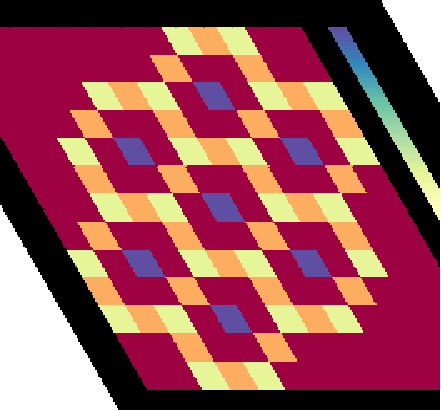

#### Can we build a house here?

In [ ]:
def check_avaliable():
    

#### Create pseudo-random resource types
Idea: we want the resource tile values to be random, but not necessarily uniform random. I propose we draw from the same procedure used to roll the dice.

In [ ]:
def roll_die():
    return sum(np.random.randint(1,7,2))

In [ ]:
def generate_terrain():
    terrain = ['Hills', 'Pasture', 'Mountains', 'Fields', 'Forest', 'Desert']
    terrain.append(random.choice(terrain))
    random.shuffle(terrain)
    
    return terrain

In [ ]:
[(tile, roll_die()) for tile in generate_terrain()]